Kaggle Quora Question Pairs MaLSTM Source
======

Firs, lets import all the necessary packages

In [1]:
# Import Learning Packages
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
#from tensorflow.python.keras.preprocessing.sequence import pad_sequences #
#from tensorflow.python.keras.models import Model #
#from tensorflow.python.keras.layers import Input, Embedding, LSTM #
from keras.preprocessing.sequence import pad_sequences #
from keras.models import Model #
from keras.layers import Input, Embedding, LSTM #
from keras.layers import Merge
import keras.backend as K
#from tensorflow.python.keras.optimizers import Adadelta #
#from tensorflow.python.keras.callbacks import ModelCheckpoint #
from keras.optimizers import Adadelta #
from keras.callbacks import ModelCheckpoint #

# Import Other Packages
import re
from time import time
import pandas as pd
import numpy as np
import itertools
import datetime

# Import Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


Global Variables

In [2]:
#File Paths
DATA_PATH = '/home/evo_mind/.kaggle/competitions/quora-question-pairs/'
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = './models/'

Create Embedding Matrix

In [3]:
# Load Training and Test Set
train_df = pd.read_csv(DATA_PATH + TRAIN_CSV)
test_df = pd.read_csv(DATA_PATH + TEST_CSV)

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre Process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()
    
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re"," are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text) 
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)    
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)    
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text) 
    
    text = text.split()
    
    return text

# Prepare Embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>'] # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(DATA_PATH+EMBEDDING_FILE, binary=True)

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():
        # Iterate through the text of both questions of the row
        for question in questions_cols:
            q2n = [] # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):
                # Check for unwanted words
                if word in stops and word not in word2vec.vocab: # 특정 word에 대해서 건너 뛴다.
                    continue
                    
                if word not in vocabulary: # unkwon word  처리 하고 있음
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])
            
            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)

embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim) # This will be the embedding matrix
embeddings[0] = 0 #  So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

/home/evo_mind/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/evo_mind/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Prepare training and validation data

In [4]:
# max seqence length 값 찾기
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)
    
# Make sure everything is OK
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [5]:
# Model Variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

In [6]:
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [7]:
# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], 
                           input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siames network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), 
                        output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size,
                           nb_epoch=n_epoch, validation_data=([X_validation['left'], X_validation['right']], 
                                                             Y_validation))

print("Training time finished. \n {} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time() - training_start_time)))

/home/evo_mind/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/evo_mind/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 364290 samples, validate on 40000 samples
Epoch 1/25
364290/364290 [==============================] - 1520s 4ms/step - loss: 0.1746 - acc: 0.7471 - val_loss: 0.1648 - val_acc: 0.7585
Epoch 2/25
364290/364290 [==============================] - 1519s 4ms/step - loss: 0.1547 - acc: 0.7823 - val_loss: 0.1543 - val_acc: 0.7876
Epoch 3/25
364290/364290 [==============================] - 1535s 4ms/step - loss: 0.1471 - acc: 0.7953 - val_loss: 0.1484 - val_acc: 0.7856
Epoch 4/25
364290/364290 [==============================] - 1535s 4ms/step - loss: 0.1425 - acc: 0.8025 - val_loss: 0.1427 - val_acc: 0.7994
Epoch 5/25
364290/364290 [==============================] - 1535s 4ms/step - loss: 0.1391 - acc: 0.8079 - val_loss: 0.1411 - val_acc: 0.8053
Epoch 6/25
364290/364290 [==============================] - 1535s 4ms/step - loss: 0.1365 - acc: 0.8116 - val_loss: 0.1403 - val_acc: 0.8017
Epoch 7/25
364290/364290 [==============================] - 1534s 4ms/step - loss: 0.1344 - acc: 0.8146

Plotting the Results

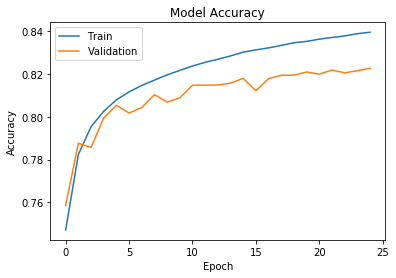

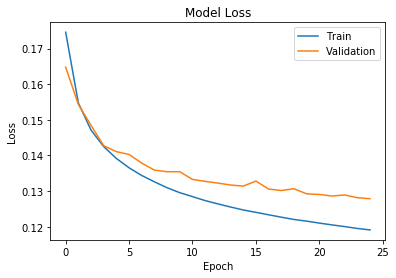

In [8]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()